# 3. Layout detection and Order reading

**Author:** Manel Carrillo, 

**Mail** manelcarrillomaillo@gmail.com

## Imports

In [7]:
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Any
import os
from matplotlib import colormaps
from paddleocr import PaddleOCR
from IPython.display import display
import pandas as pd
from pytesseract import Output
from paddleocr import LayoutDetection
from PIL import Image, ImageOps, ImageEnhance

## Paths


C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK` to `True`.
C:\Users\manel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached fi

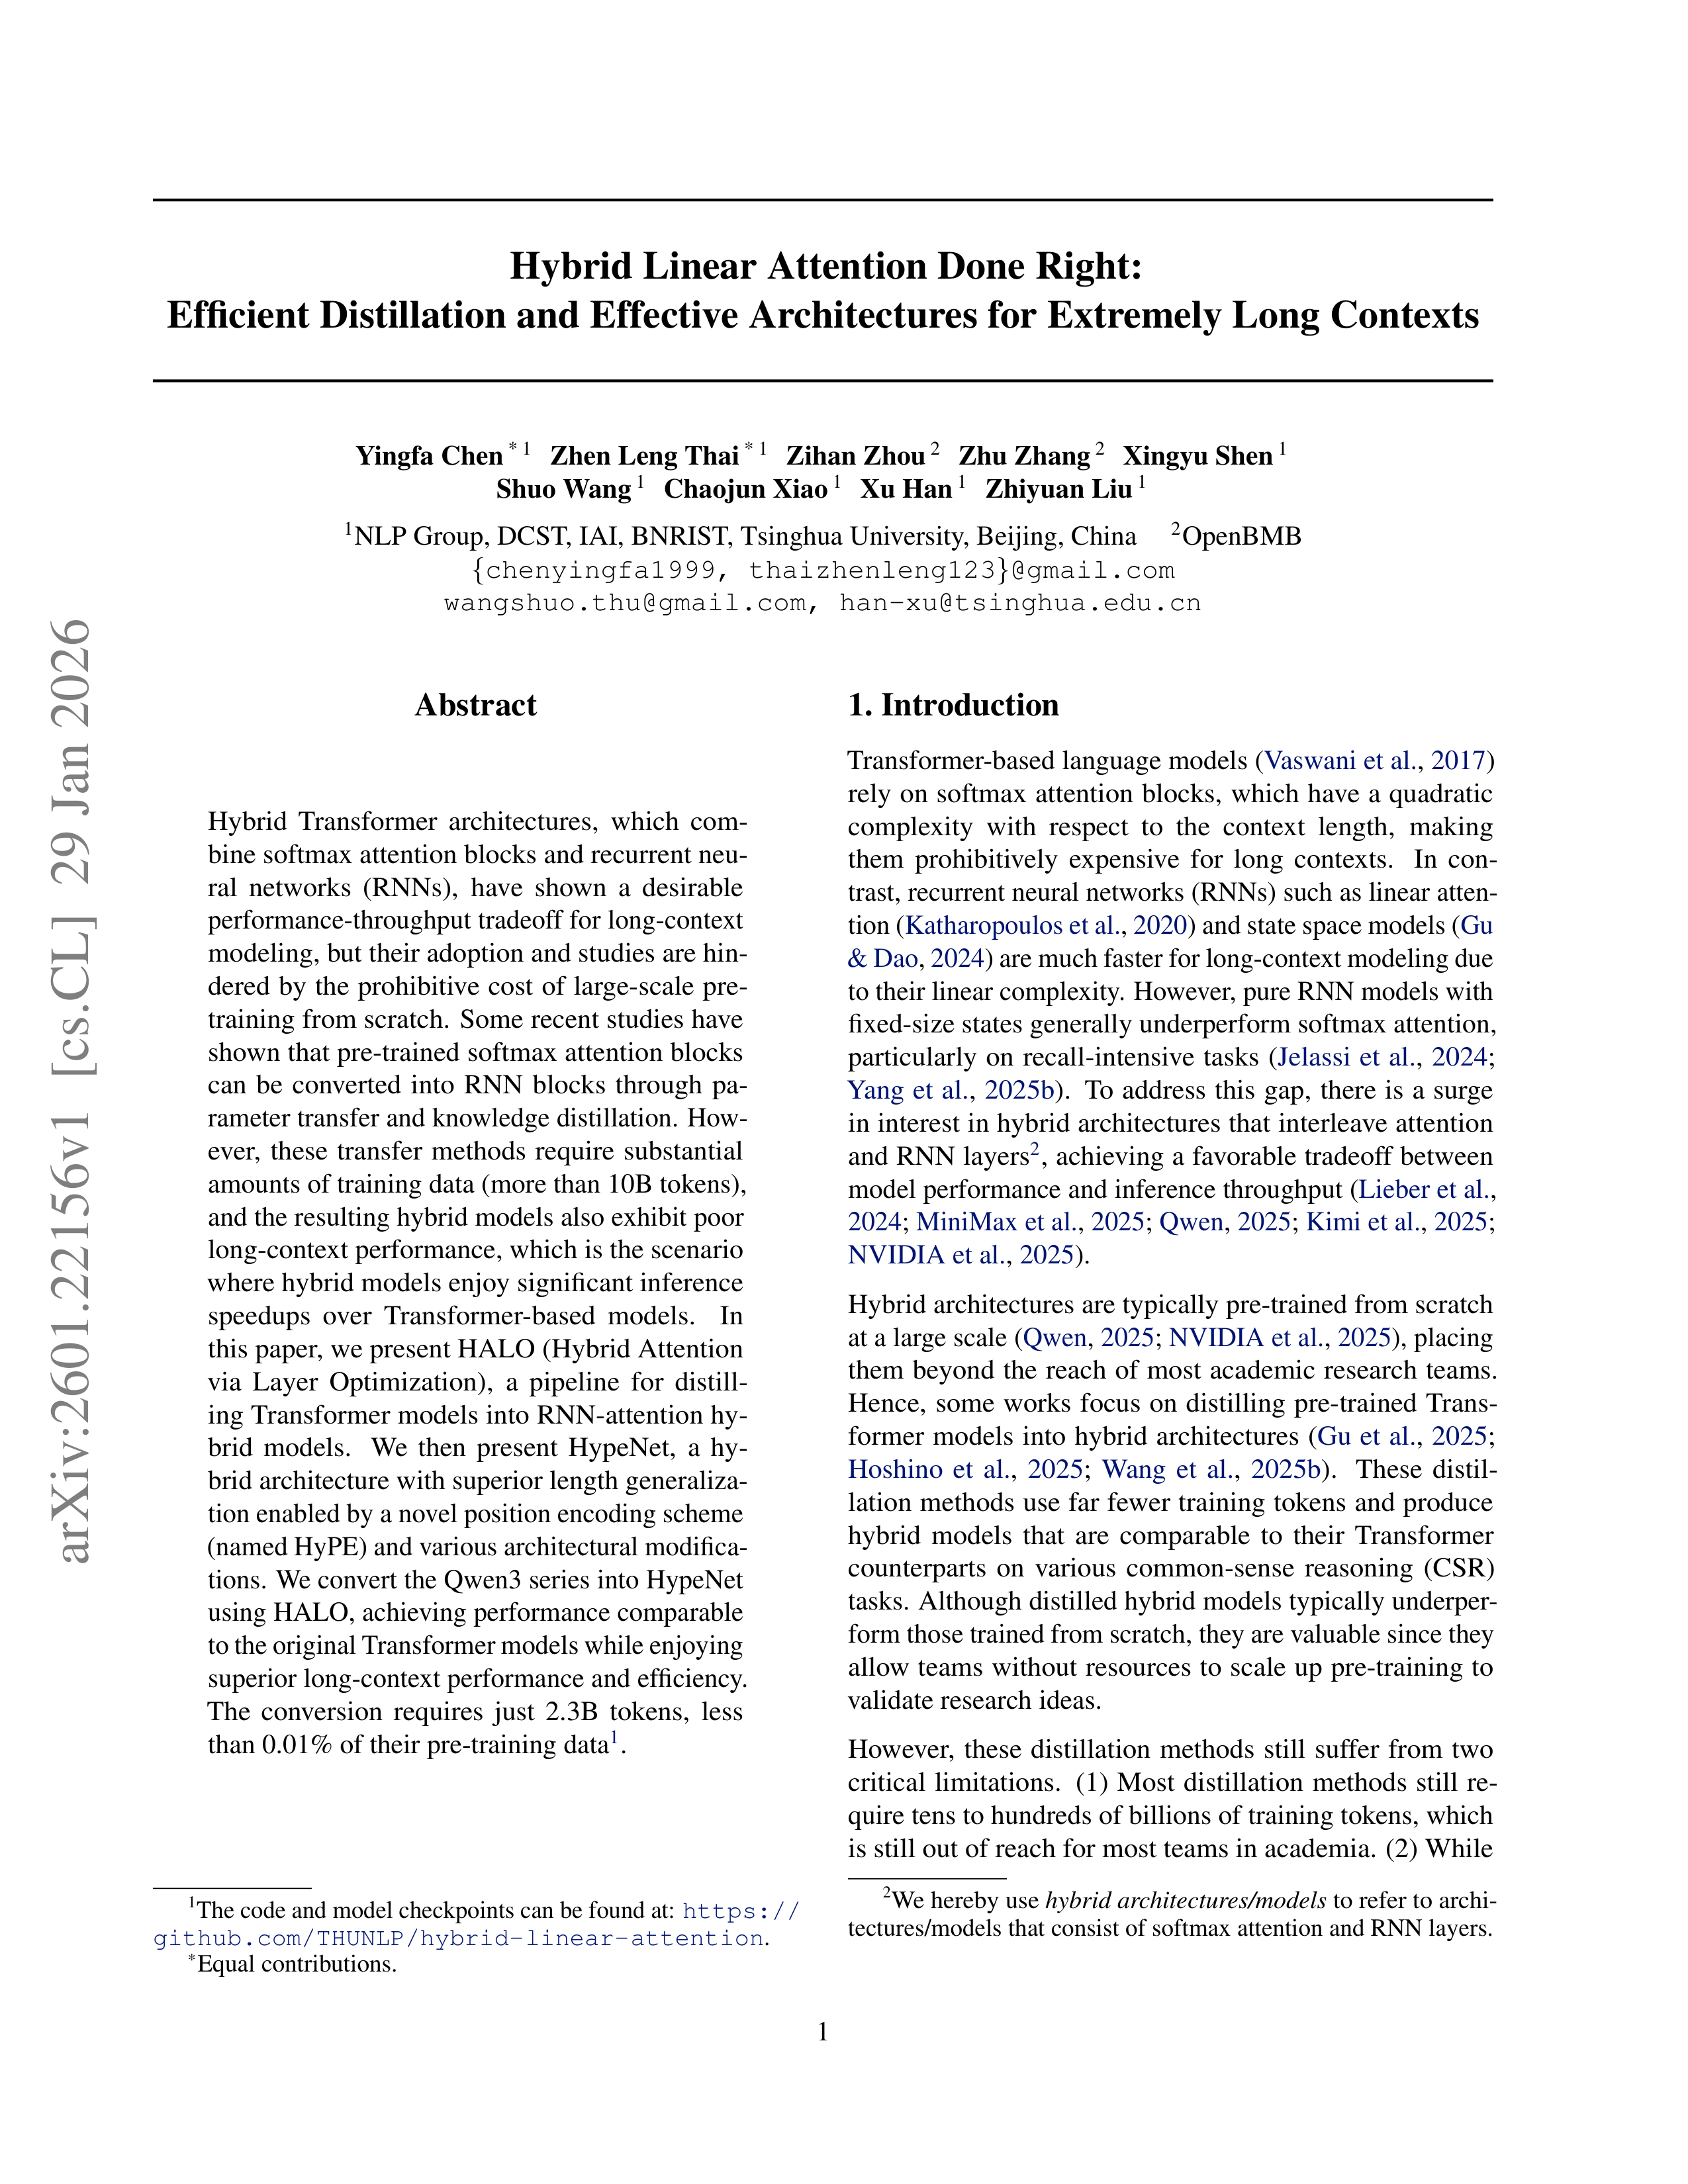

In [ ]:
ocr = PaddleOCR(lang='en')
PATH1 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_1.png'
PATH2 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_2.png'
PATH3 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_3.png'
PATH4 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/page_7.png'
PATH5 = 'c:/Users/manel/OneDrive/Escritorio/OCR/DocumentAgent/data/images/TFG1.png'

## Functions from paddleOCR notebook

In [ ]:
layout_engine = LayoutDetection()

In [8]:
def extract_layout_regions(
    image_path,
    layout_engine,
    min_confidence=0.0,
    sort_by="confidence"  # "confidence" | "top_to_bottom"
):
    """
    Run layout detection and return structured layout regions.

    Parameters
    ----------
    image_path : str or Path
        Path to input image.
    layout_engine : object
        PaddleOCR layout engine (already initialized).
    min_confidence : float
        Minimum confidence threshold.
    sort_by : str
        Sorting strategy:
        - "confidence": descending confidence
        - "top_to_bottom": reading-order-like (y, then x)

    Returns
    -------
    List[dict]
        Each dict contains: label, score, bbox, cx, cy
    """
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")

    layout_result = layout_engine.predict(str(image_path))

    if not layout_result or "boxes" not in layout_result[0]:
        raise ValueError("Invalid layout detection output.")

    regions = []
    for box in layout_result[0]["boxes"]:
        score = float(box["score"])
        if score < min_confidence:
            continue

        x1, y1, x2, y2 = box["coordinate"]
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        regions.append({
            "label": box["label"],
            "score": score,
            "bbox": [x1, y1, x2, y2],
            "cx": cx,
            "cy": cy
        })

    if sort_by == "confidence":
        regions.sort(key=lambda r: r["score"], reverse=True)
    elif sort_by == "top_to_bottom":
        regions.sort(key=lambda r: (r["cy"], r["cx"]))
    else:
        raise ValueError(f"Unknown sort_by='{sort_by}'")

    return regions

def visualize_layout_regions(
    image_path,
    regions,
    figsize=(10, 12),
    show_labels=True,
    line_thickness=2,
    font_scale=0.6
):
    """
    Visualize layout regions on the image.

    Parameters
    ----------
    image_path : str or Path
        Path to input image.
    regions : List[dict]
        Output from extract_layout_regions.
    """
    image_path = Path(image_path)
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"cv2.imread failed for {image_path}")

    img_plot = img.copy()

    labels = sorted(set(r["label"] for r in regions))
    cmap = colormaps.get_cmap("tab20")

    color_map = {
        label: (
            int(cmap(i)[2] * 255),
            int(cmap(i)[1] * 255),
            int(cmap(i)[0] * 255),
        )
        for i, label in enumerate(labels)
    }

    for r in regions:
        x1, y1, x2, y2 = map(int, r["bbox"])
        color = color_map[r["label"]]

        pts = np.array(
            [[x1, y1], [x2, y1], [x2, y2], [x1, y2]],
            dtype=int
        )

        cv2.polylines(img_plot, [pts], True, color, line_thickness)

        if show_labels:
            text = f"{r['label']} ({r['score']:.2f})"
            cv2.putText(
                img_plot,
                text,
                (x1, max(0, y1 - 8)),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                color,
                2,
                cv2.LINE_AA
            )

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Layout Detection (PaddleOCR)")
    plt.show()

    return img_plot

In [ ]:
regions = extract_layout_regions(
    image_path=PATH3,
    layout_engine=layout_engine,
    min_confidence=0.5,
    sort_by="top_to_bottom"
)

visualize_layout_regions(



    
    image_path=PATH3,
    regions=regions
)

In [ ]:
from transformers import LayoutLMv3ForTokenClassification
from layoutreader.v3.helpers import prepare_inputs, boxes2inputs, parse_logits

# Load LayoutReader model
print("Loading LayoutReader model...")
model_slug = "hantian/layoutreader"
layout_model = LayoutLMv3ForTokenClassification.from_pretrained(model_slug)
print("Model loaded successfully!")